C:\Users\sannj\AppData\Local\Temp\ipykernel_12512\3215335512.py:49: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql(query, conn)
C:\Users\sannj\AppData\Local\Temp\ipykernel_12512\3215335512.py:138: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  summary_original = df.groupby(['facility_name', 'model_type'])['maintenance_needed'].agg(['sum', 'count']).reset_index()
C:\Users\sannj\AppData\Local\Temp\ipykernel_12512\3215335512.py:142: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future 


Original Model - Facility and Model-Type Maintenance Risk Summary:
       facility_name model_type  robots_flagged  total_robots  percent_flagged
0   London Facility   Painting               4            10        40.000000
1   London Facility    Welding               7            11        63.636364
2  Toronto Facility   Painting               7             9        77.777778
3  Toronto Facility    Welding               6            12        50.000000

Enhanced Model - Facility and Model-Type Maintenance Risk Summary:
       facility_name model_type  robots_flagged  total_robots  percent_flagged
0   London Facility   Painting               2            10        20.000000
1   London Facility    Welding               5            11        45.454545
2  Toronto Facility   Painting               4             9        44.444444
3  Toronto Facility    Welding               2            12        16.666667

Original Random Forest Confusion Matrix:
 [[6 0]
 [0 6]]

Original Random Forest 

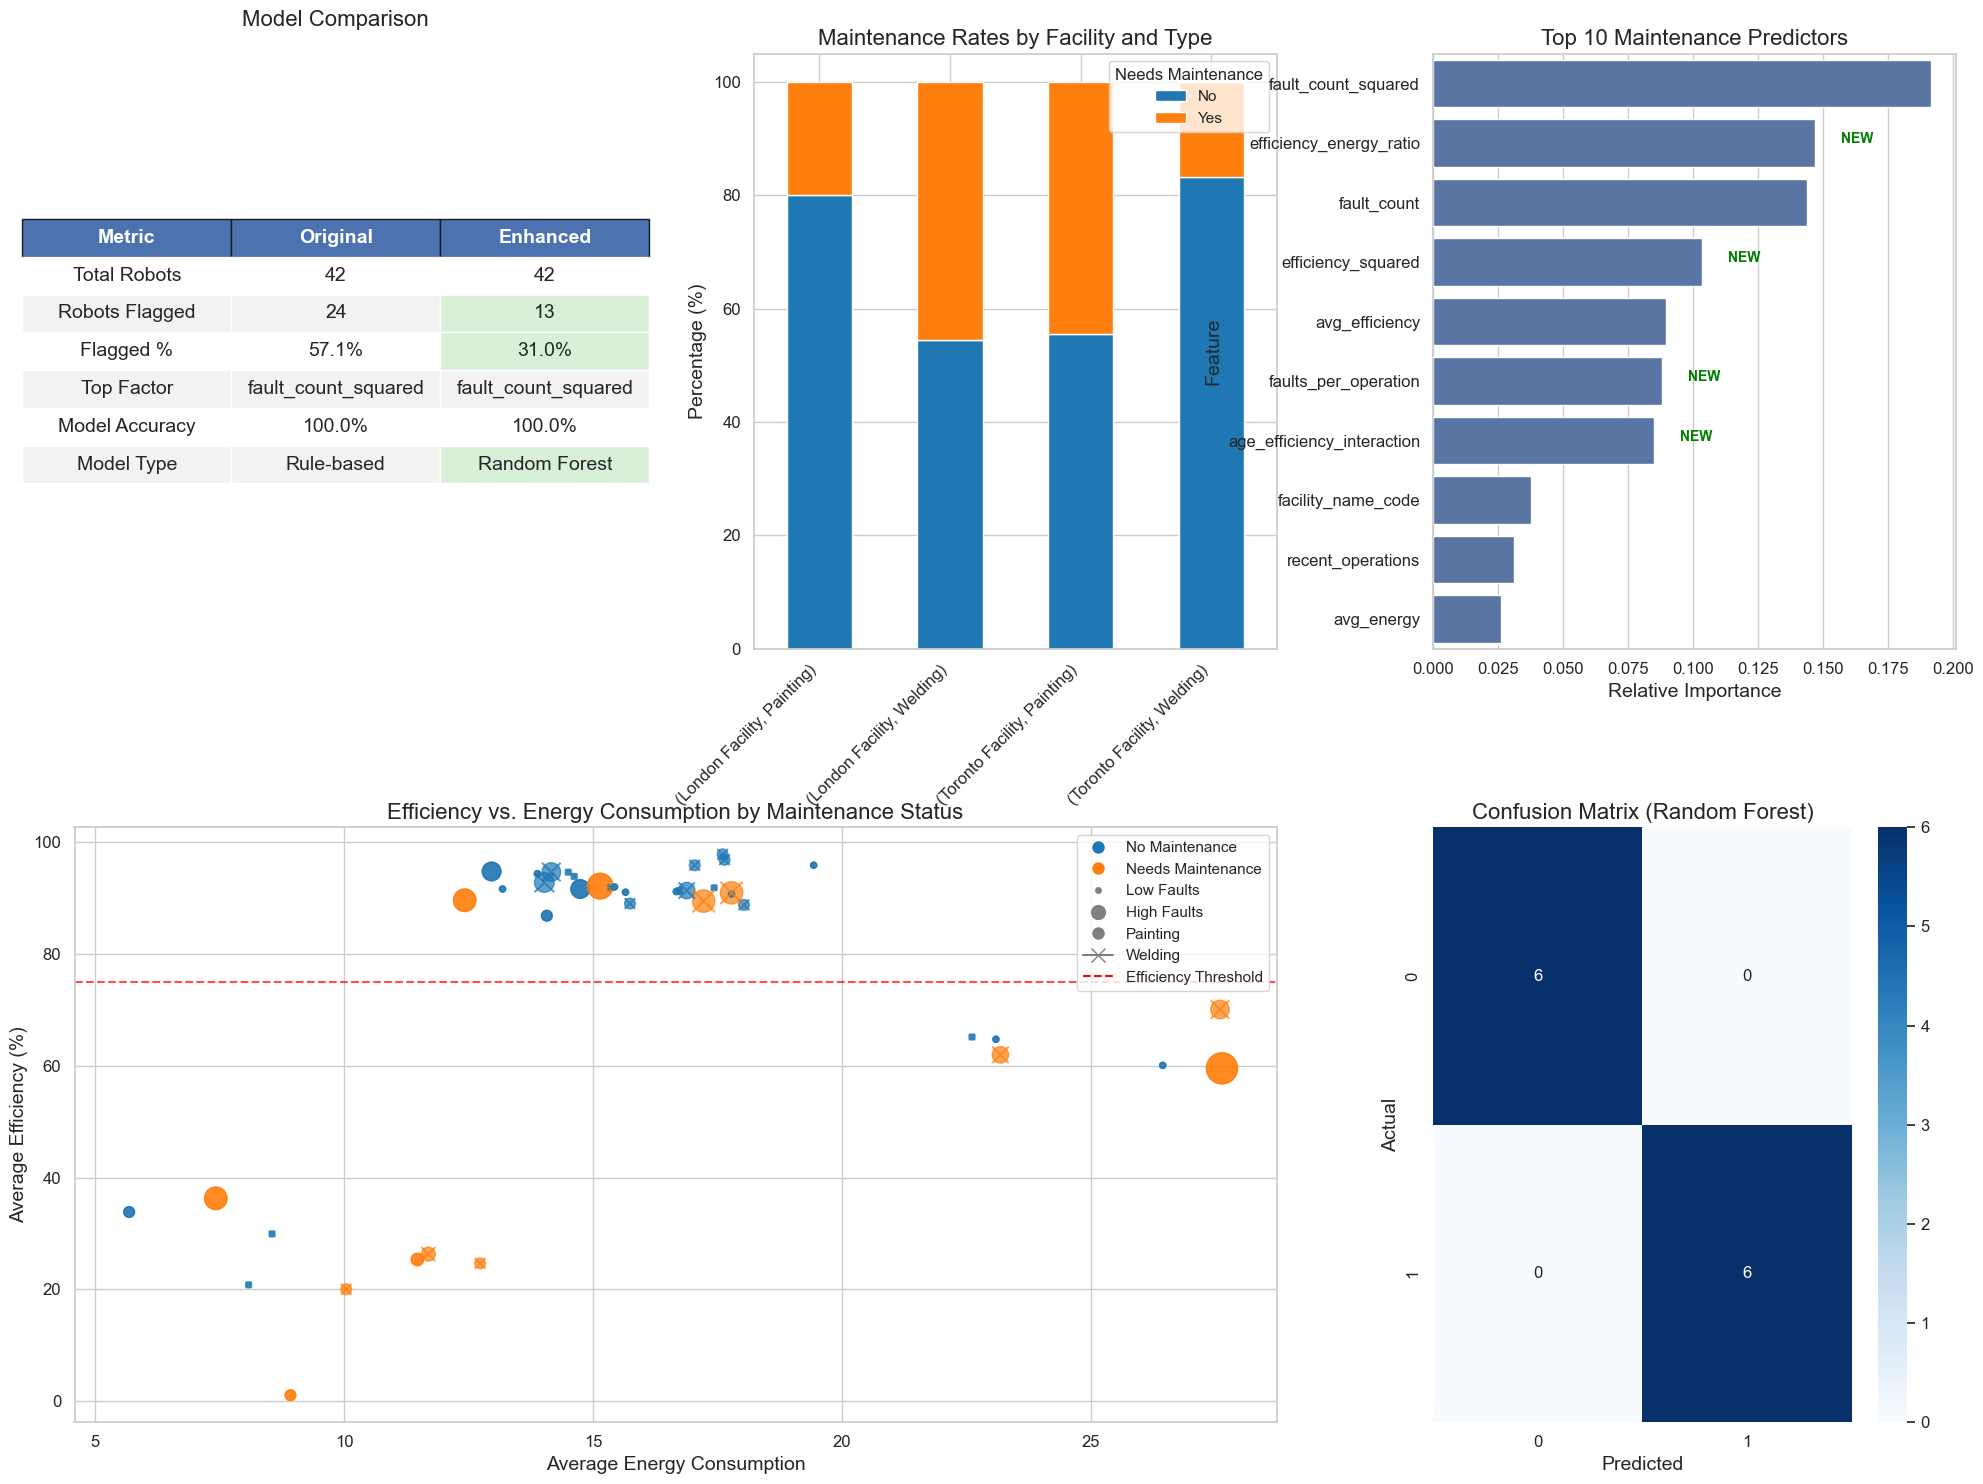

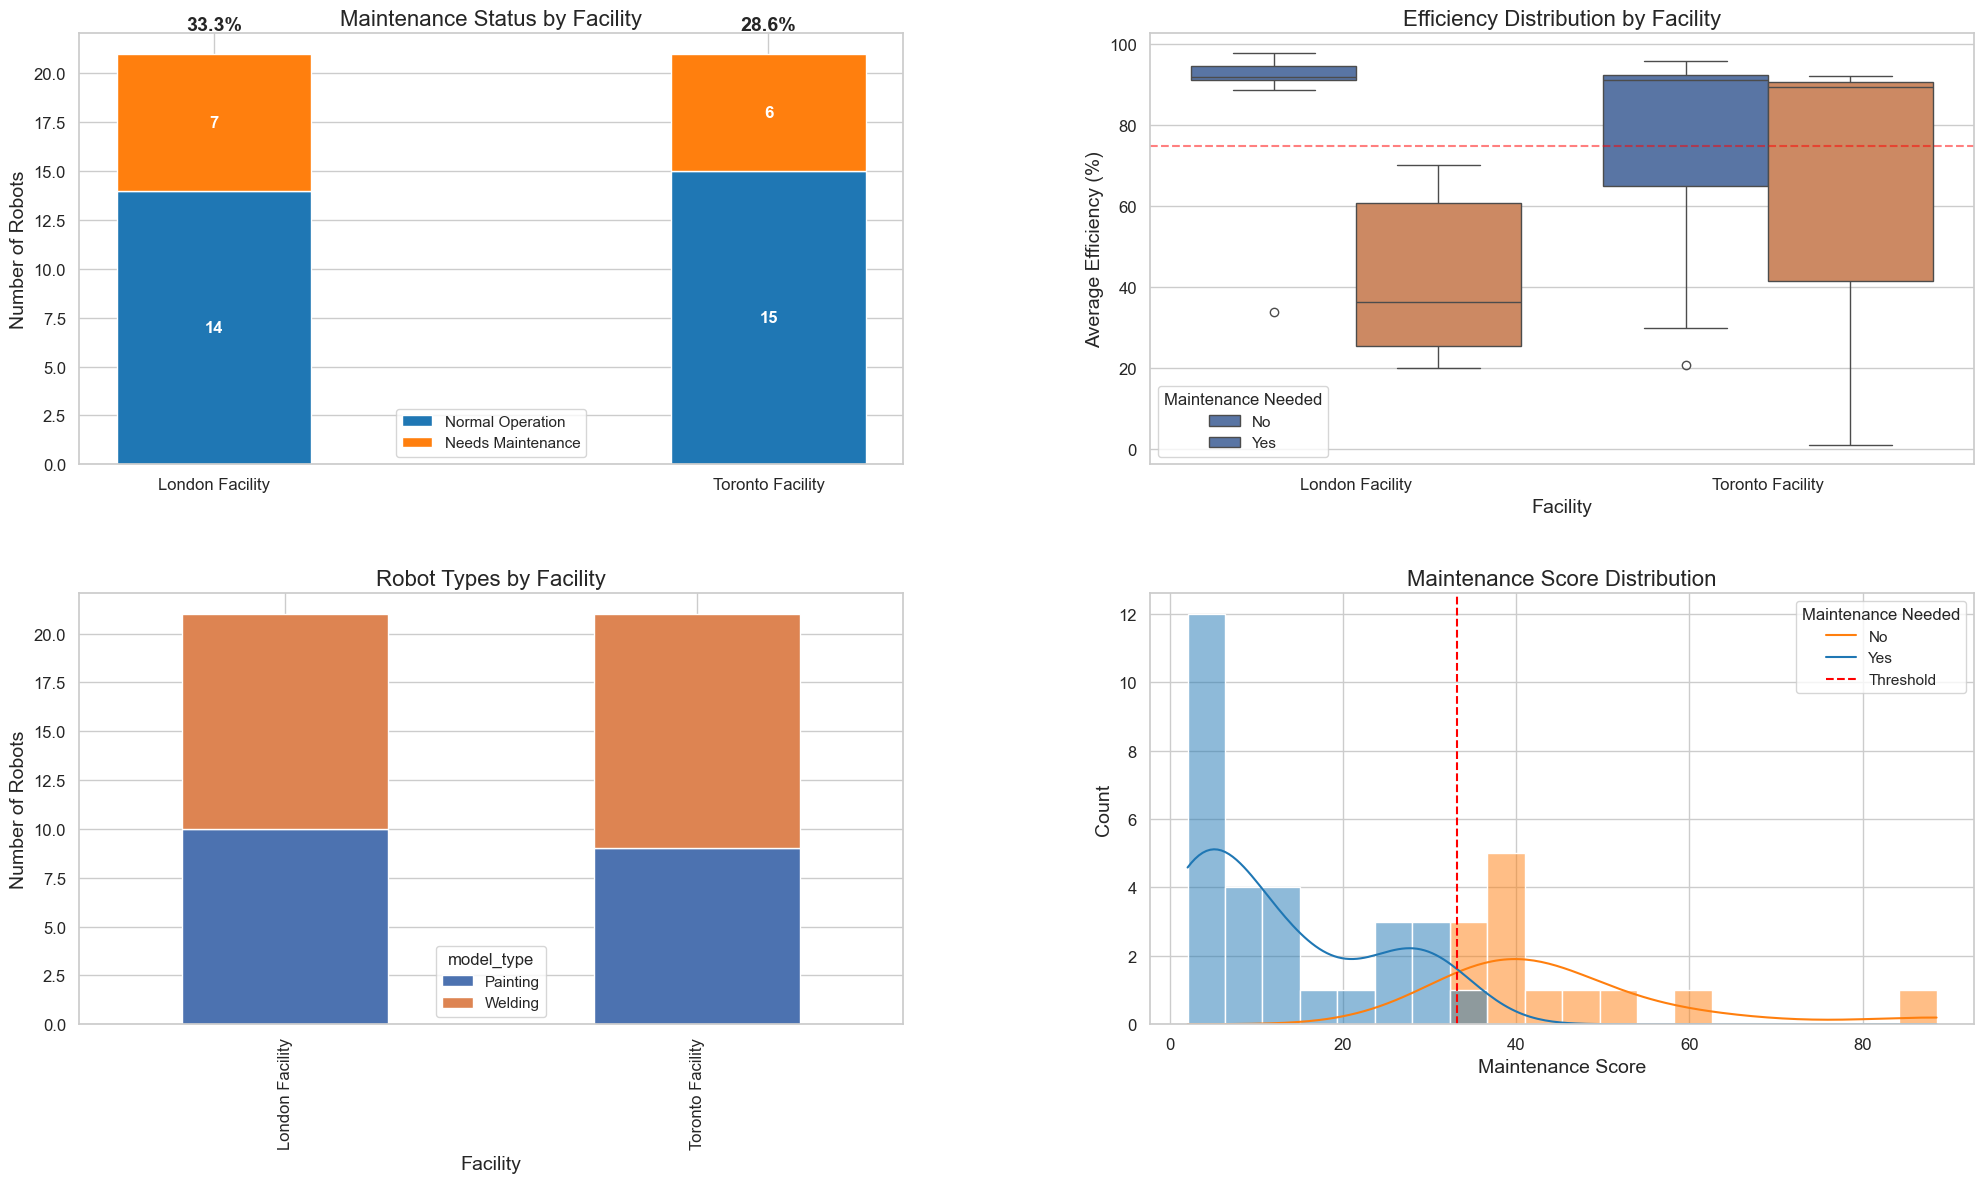

C:\Users\sannj\AppData\Local\Temp\ipykernel_12512\3215335512.py:376: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  priority_count = df.groupby('priority').size().reset_index(name='count')
C:\Users\sannj\AppData\Local\Temp\ipykernel_12512\3215335512.py:407: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  timeline_counts = df.groupby(['maintenance_timeline', 'facility_name']).size().reset_index(name='count')


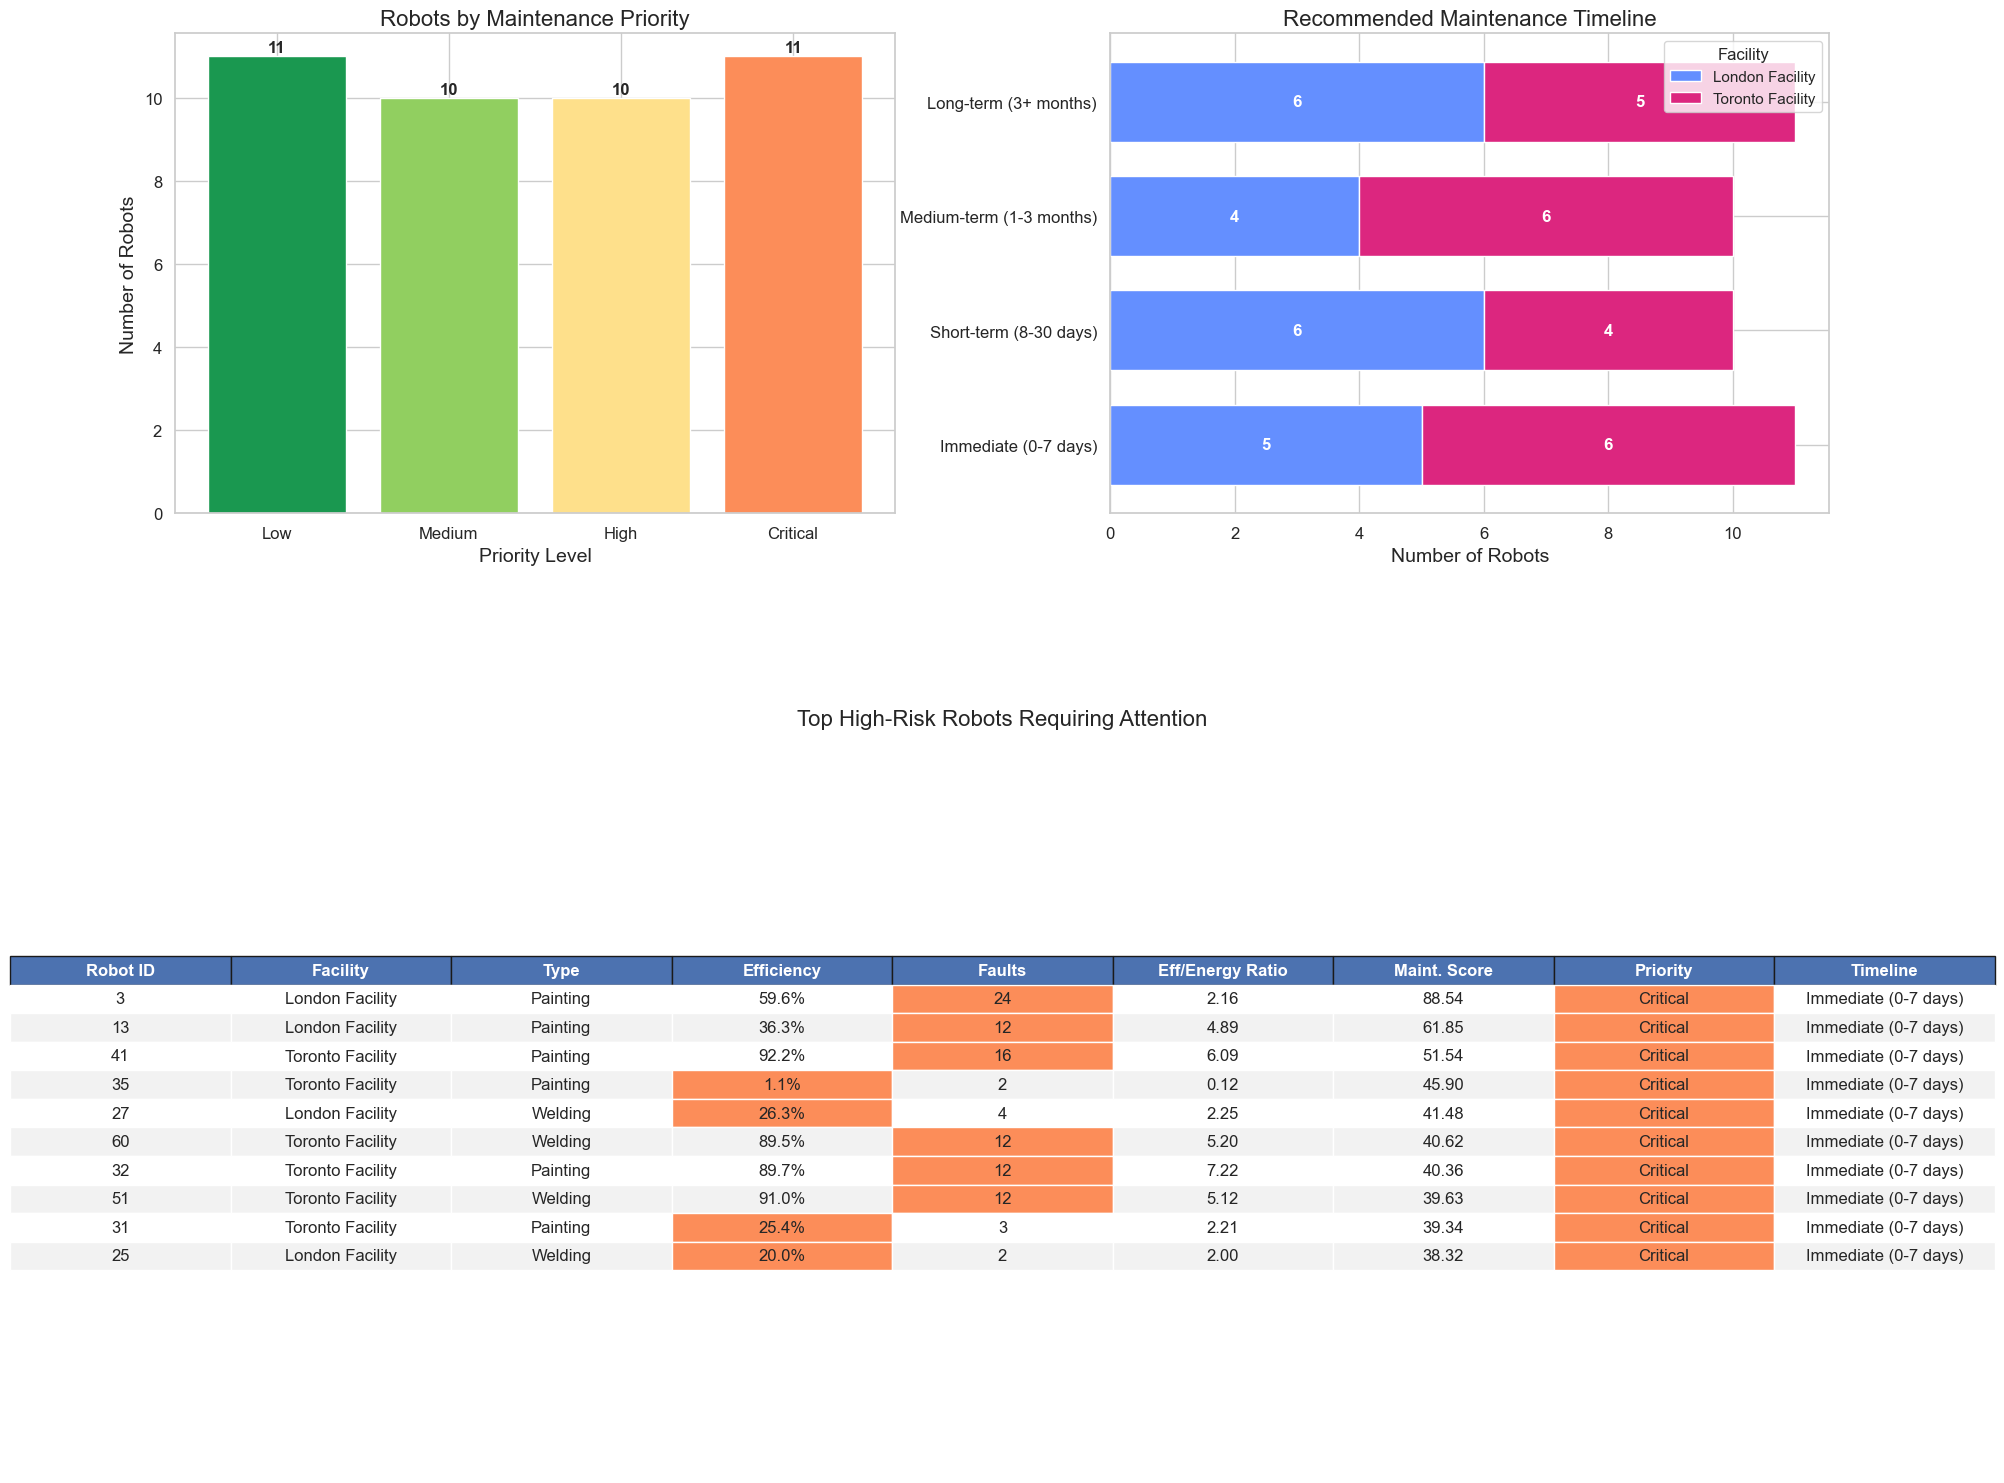


Analysis complete! The enhanced model has improved maintenance predictions.
Top maintenance predictors are: fault_count_squared, efficiency_energy_ratio, fault_count
Model accuracy: 100.0%
Maintenance threshold score: 33.19
Number of robots flagged for maintenance: 13 out of 42 (31.0%)


In [14]:
import pandas as pd
import numpy as np
import mysql.connector
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE
import matplotlib.gridspec as gridspec
from matplotlib.colors import LinearSegmentedColormap
from matplotlib.lines import Line2D

# Connect to MySQL and fetch data
db_config = {
    'user': 'root',
    'password': 'admin',
    'host': 'localhost',
    'database': 'RobotAnalytics',
    'allow_local_infile': True
}

conn = mysql.connector.connect(**db_config)
query = """
    SELECT
        r.robot_id,
        f.facility_name,
        rm.model_type,
        DATEDIFF(NOW(), r.installation_date) AS robot_age_days,
        ROUND(AVG(pm.efficiency), 2) AS avg_efficiency,
        ROUND(AVG(pm.energy_consumption), 2) AS avg_energy,
        COUNT(el.event_id) AS fault_count,
        COUNT(ol.operation_id) AS recent_operations,
        SUM(CASE WHEN ol.success = 0 THEN 1 ELSE 0 END) AS failed_operations,
        CASE WHEN COUNT(el.event_id) > 3 OR AVG(pm.efficiency) < 75 THEN 1 ELSE 0 END AS maintenance_needed
    FROM Robots r
    JOIN RobotModels rm ON r.model_id = rm.model_id
    JOIN Facilities f ON r.facility_id = f.facility_id
    LEFT JOIN PerformanceMetrics pm ON r.robot_id = pm.robot_id
        AND pm.timestamp >= NOW() - INTERVAL 90 DAY
    LEFT JOIN EventLogs el ON r.robot_id = el.robot_id
        AND el.event_timestamp >= NOW() - INTERVAL 90 DAY
    LEFT JOIN OperationLogs ol ON r.robot_id = ol.robot_id
        AND ol.start_time >= NOW() - INTERVAL 90 DAY
    GROUP BY r.robot_id, f.facility_name, rm.model_type, r.installation_date
    HAVING avg_efficiency IS NOT NULL AND avg_energy IS NOT NULL
"""
df = pd.read_sql(query, conn)
conn.close()

# Encode categorical variables
df['model_type'] = df['model_type'].astype('category')
df['model_type_code'] = df['model_type'].cat.codes
df['facility_name_code'] = df['facility_name'].astype('category').cat.codes

# Calculate success ratio
df['success_ratio'] = (df['recent_operations'] - df['failed_operations']) / df['recent_operations']
df['success_ratio'] = df['success_ratio'].fillna(0)  # Handle division by zero

# Age grouping
df['age_group'] = pd.cut(df['robot_age_days'], bins=[0, 180, 365, 730, float('inf')], 
                        labels=['<6 months', '6-12 months', '1-2 years', '>2 years'])

# ==================== FEATURE ENGINEERING ====================
# Add interaction features
df['efficiency_energy_ratio'] = df['avg_efficiency'] / df['avg_energy']
df['faults_per_operation'] = df['fault_count'] / df['recent_operations'].replace(0, 1)
df['energy_per_operation'] = df['avg_energy'] / df['recent_operations'].replace(0, 1)
df['age_efficiency_interaction'] = df['robot_age_days'] * (100 - df['avg_efficiency']) / 100

# Add polynomial features for key variables
df['efficiency_squared'] = df['avg_efficiency'] ** 2
df['fault_count_squared'] = df['fault_count'] ** 2

# Create a more nuanced maintenance score
df['maintenance_score'] = (
    (100 - df['avg_efficiency']) * 0.4 + 
    (df['fault_count'] * 10) * 0.3 + 
    (df['failed_operations'] / df['recent_operations'].replace(0, 1)) * 0.2 + 
    (df['robot_age_days'] / 365) * 0.1
)

# Define a new target based on this score
threshold = df['maintenance_score'].quantile(0.7)  # Top 30% need maintenance
df['maintenance_needed_new'] = (df['maintenance_score'] > threshold).astype(int)

# Define features and target
X_original = df[['robot_age_days', 'avg_efficiency', 'avg_energy', 'fault_count',
        'recent_operations', 'failed_operations', 'model_type_code', 'facility_name_code']]
y_original = df['maintenance_needed']

# Create enhanced feature set
X_enhanced = df[['robot_age_days', 'avg_efficiency', 'avg_energy', 'fault_count',
                'recent_operations', 'failed_operations', 'model_type_code', 'facility_name_code',
                'efficiency_energy_ratio', 'faults_per_operation', 'energy_per_operation',
                'age_efficiency_interaction', 'efficiency_squared', 'fault_count_squared']]
y_enhanced = df['maintenance_needed_new']  # Use the more nuanced target

# Balance dataset with SMOTE
smote = SMOTE(random_state=42)
X_res, y_res = smote.fit_resample(X_enhanced, y_enhanced)

# Train/Test split and scale
X_train, X_test, y_train, y_test = train_test_split(X_res, y_res, test_size=0.2, random_state=42)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Train models
rf_model = RandomForestClassifier(n_estimators=100, random_state=42, class_weight='balanced')
rf_model.fit(X_train_scaled, y_train)
y_pred_rf = rf_model.predict(X_test_scaled)

# Also try GradientBoosting for comparison
gb_model = GradientBoostingClassifier(random_state=42)
gb_model.fit(X_train_scaled, y_train)
y_pred_gb = gb_model.predict(X_test_scaled)

# Choose the best model based on F1 score
rf_f1 = f1_score(y_test, y_pred_rf)
gb_f1 = f1_score(y_test, y_pred_gb)

if rf_f1 >= gb_f1:
    best_model = rf_model
    best_model_name = "Random Forest"
    y_pred = y_pred_rf
else:
    best_model = gb_model
    best_model_name = "Gradient Boosting"
    y_pred = y_pred_gb

# Add predictions to original df for insights
df['predicted_maintenance_original'] = y_original  # This is the original maintenance flag from the query
df['predicted_maintenance_enhanced'] = best_model.predict(scaler.transform(X_enhanced))

# Create two summary outputs
summary_original = df.groupby(['facility_name', 'model_type'])['maintenance_needed'].agg(['sum', 'count']).reset_index()
summary_original.rename(columns={'sum': 'robots_flagged', 'count': 'total_robots'}, inplace=True)
summary_original['percent_flagged'] = (summary_original['robots_flagged'] / summary_original['total_robots']) * 100

summary_enhanced = df.groupby(['facility_name', 'model_type'])['predicted_maintenance_enhanced'].agg(['sum', 'count']).reset_index()
summary_enhanced.rename(columns={'sum': 'robots_flagged', 'count': 'total_robots'}, inplace=True)
summary_enhanced['percent_flagged'] = (summary_enhanced['robots_flagged'] / summary_enhanced['total_robots']) * 100

print("\nOriginal Model - Facility and Model-Type Maintenance Risk Summary:\n", summary_original)
print("\nEnhanced Model - Facility and Model-Type Maintenance Risk Summary:\n", summary_enhanced)

# Print model performance metrics
print("\nOriginal Random Forest Confusion Matrix:\n", confusion_matrix(y_test, y_pred_rf))
print("\nOriginal Random Forest Classification Report:\n", classification_report(y_test, y_pred_rf))

print(f"\nBest Model ({best_model_name}) Classification Report:\n", classification_report(y_test, y_pred))

# Get feature importance
feature_importance = pd.DataFrame({
    'Feature': X_enhanced.columns,
    'Importance': best_model.feature_importances_
}).sort_values('Importance', ascending=False)

print("\nTop 10 Feature Importance:\n", feature_importance.head(10))

# ==================== DASHBOARD 1: MAINTENANCE OVERVIEW ====================
plt.figure(figsize=(20, 15))
gs = gridspec.GridSpec(2, 3, height_ratios=[1, 1])

# 1. Top Metrics - Now comparing original vs enhanced models
ax0 = plt.subplot(gs[0, 0])
total_robots = len(df)
flagged_robots_original = df['maintenance_needed'].sum()
flagged_robots_enhanced = df['predicted_maintenance_enhanced'].sum()
flagged_percent_original = (flagged_robots_original / total_robots) * 100
flagged_percent_enhanced = (flagged_robots_enhanced / total_robots) * 100

# Get accuracies from the classification reports
original_accuracy = accuracy_score(y_test, y_pred_rf) * 100
enhanced_accuracy = accuracy_score(y_test, y_pred) * 100

metrics_data = [
    ['Metric', 'Original', 'Enhanced'],
    ['Total Robots', total_robots, total_robots],
    ['Robots Flagged', flagged_robots_original, flagged_robots_enhanced],
    ['Flagged %', f"{flagged_percent_original:.1f}%", f"{flagged_percent_enhanced:.1f}%"],
    ['Top Factor', feature_importance.iloc[0]['Feature'], feature_importance.iloc[0]['Feature']],
    ['Model Accuracy', f"{original_accuracy:.1f}%", f"{enhanced_accuracy:.1f}%"],
    ['Model Type', 'Rule-based', best_model_name]
]

# Create a table
ax0.axis('tight')
ax0.axis('off')
table = ax0.table(cellText=metrics_data, loc='center', cellLoc='center')
table.auto_set_font_size(False)
table.set_fontsize(14)
table.scale(1.2, 2)

# Style the table
for key, cell in table.get_celld().items():
    if key[0] == 0:  # Make the header row bold
        cell.set_text_props(weight='bold')
        cell.set_facecolor('#4c72b0')
        cell.set_text_props(color='white')
    else:
        cell.set_edgecolor('white')
        if key[0] % 2 == 0:
            cell.set_facecolor('#f2f2f2')
        else:
            cell.set_facecolor('white')
            
        # Highlight differences between models
        if key[0] > 1 and key[1] > 1:  # Not the first row or column
            if key[1] == 2 and metrics_data[key[0]][1] != metrics_data[key[0]][2]:
                cell.set_facecolor('#d8f0d8')  # Light green for enhanced model improvements

ax0.set_title("Model Comparison", pad=20)

# 2. Maintenance Rates by Facility and Type
ax1 = plt.subplot(gs[0, 1])
maintenance_colors = ['#1f77b4', '#ff7f0e']  # Blue for no maintenance, Orange for maintenance needed

cross_tab = pd.crosstab(
    [df['facility_name'], df['model_type']], 
    df['predicted_maintenance_enhanced'],
    normalize='index'
) * 100
cross_tab.plot(kind='bar', stacked=True, ax=ax1, color=maintenance_colors)
ax1.set_title('Maintenance Rates by Facility and Type')
ax1.set_xlabel('')
ax1.set_ylabel('Percentage (%)')
ax1.legend(title='Needs Maintenance', labels=['No', 'Yes'])
ax1.set_xticklabels(ax1.get_xticklabels(), rotation=45, ha='right')

# 3. Feature Importance
ax2 = plt.subplot(gs[0, 2])
top_features = feature_importance.head(10)  # Top 10 features
sns.barplot(data=top_features, x='Importance', y='Feature', ax=ax2)
ax2.set_title('Top 10 Maintenance Predictors')
ax2.set_xlabel('Relative Importance')

# Add text annotations for new vs original features
for i, feature in enumerate(top_features['Feature']):
    if feature not in X_original.columns:
        ax2.annotate('NEW', (top_features.iloc[i]['Importance']+0.01, i), 
                    color='green', weight='bold', fontsize=10)

# 4. Efficiency vs. Energy with Fault Count
ax3 = plt.subplot(gs[1, 0:2])
scatter = ax3.scatter(df['avg_energy'], df['avg_efficiency'], 
                      c=df['predicted_maintenance_enhanced'], s=df['fault_count']*20+20, 
                      cmap=LinearSegmentedColormap.from_list('', maintenance_colors), 
                      alpha=0.7)

# Add marker style for robot type
for model_type, marker in [('Painting', 'o'), ('Welding', 'x')]:
    mask = df['model_type'] == model_type
    ax3.scatter(df.loc[mask, 'avg_energy'], df.loc[mask, 'avg_efficiency'], 
                c=df.loc[mask, 'predicted_maintenance_enhanced'], 
                s=df.loc[mask, 'fault_count']*20+20, 
                cmap=LinearSegmentedColormap.from_list('', maintenance_colors),
                marker=marker, alpha=0.7)

# Add efficiency threshold line
ax3.axhline(y=75, color='red', linestyle='--', alpha=0.7, label='Efficiency Threshold (75%)')

# Create custom legend
legend_elements = [
    Line2D([0], [0], marker='o', color='w', markerfacecolor=maintenance_colors[0], markersize=10, label='No Maintenance'),
    Line2D([0], [0], marker='o', color='w', markerfacecolor=maintenance_colors[1], markersize=10, label='Needs Maintenance'),
    Line2D([0], [0], marker='o', color='w', markerfacecolor='gray', markersize=6, label='Low Faults'),
    Line2D([0], [0], marker='o', color='w', markerfacecolor='gray', markersize=12, label='High Faults'),
    Line2D([0], [0], marker='o', color='w', markerfacecolor='gray', markersize=10, label='Painting'),
    Line2D([0], [0], marker='x', color='gray', markersize=10, label='Welding'),
    Line2D([0], [0], color='red', linestyle='--', label='Efficiency Threshold')
]
ax3.legend(handles=legend_elements, loc='upper right', bbox_to_anchor=(1, 1))

ax3.set_title('Efficiency vs. Energy Consumption by Maintenance Status')
ax3.set_xlabel('Average Energy Consumption')
ax3.set_ylabel('Average Efficiency (%)')

# 5. Confusion Matrix
ax4 = plt.subplot(gs[1, 2])
conf_matrix = confusion_matrix(y_test, y_pred)
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', ax=ax4)
ax4.set_title(f'Confusion Matrix ({best_model_name})')
ax4.set_xlabel('Predicted')
ax4.set_ylabel('Actual')

plt.tight_layout()
plt.subplots_adjust(wspace=0.3, hspace=0.3)
plt.savefig('maintenance_overview_dashboard.png', dpi=300, bbox_inches='tight')
plt.show()

# ==================== DASHBOARD 2: FACILITY COMPARISON ====================
plt.figure(figsize=(20, 12))
gs = gridspec.GridSpec(2, 2)

# 1. Maintenance Rate Comparison by Facility
ax1 = plt.subplot(gs[0, 0])
facility_summary = df.groupby('facility_name')['predicted_maintenance_enhanced'].agg(['mean', 'count']).reset_index()
facility_summary['maintenance_rate'] = facility_summary['mean'] * 100
facility_summary['normal_count'] = facility_summary['count'] - (facility_summary['mean'] * facility_summary['count'])
facility_summary['maintenance_count'] = facility_summary['mean'] * facility_summary['count']

# Create stacked bar chart
bar_width = 0.35
x = np.arange(len(facility_summary))
ax1.bar(x, facility_summary['normal_count'], bar_width, label='Normal Operation', color=maintenance_colors[0])
ax1.bar(x, facility_summary['maintenance_count'], bar_width, bottom=facility_summary['normal_count'], 
       label='Needs Maintenance', color=maintenance_colors[1])

# Add count and percentage labels
for i, row in facility_summary.iterrows():
    # Add maintenance percentage
    ax1.text(i, row['count'] + 1, f"{row['maintenance_rate']:.1f}%", 
             ha='center', va='bottom', fontsize=14, fontweight='bold')
    
    # Add counts on the bars
    ax1.text(i, row['normal_count']/2, f"{int(row['normal_count'])}", 
             ha='center', va='center', color='white', fontweight='bold')
    ax1.text(i, row['normal_count'] + row['maintenance_count']/2, f"{int(row['maintenance_count'])}", 
             ha='center', va='center', color='white', fontweight='bold')

ax1.set_ylabel('Number of Robots')
ax1.set_title('Maintenance Status by Facility')
ax1.set_xticks(x)
ax1.set_xticklabels(facility_summary['facility_name'])
ax1.legend()

# 2. Efficiency Distribution by Facility
ax2 = plt.subplot(gs[0, 1])
sns.boxplot(data=df, x='facility_name', y='avg_efficiency', hue='predicted_maintenance_enhanced', ax=ax2)
ax2.set_title('Efficiency Distribution by Facility')
ax2.set_xlabel('Facility')
ax2.set_ylabel('Average Efficiency (%)')
ax2.axhline(y=75, color='red', linestyle='--', alpha=0.5, label='Threshold')
ax2.legend(title='Maintenance Needed', labels=['No', 'Yes'])

# 3. Robot Types by Facility
ax3 = plt.subplot(gs[1, 0])
facility_model_counts = pd.crosstab(df['facility_name'], df['model_type'])
facility_model_counts.plot(kind='bar', stacked=True, ax=ax3)
ax3.set_title('Robot Types by Facility')
ax3.set_xlabel('Facility')
ax3.set_ylabel('Number of Robots')

# 4. Maintenance Score Distribution
ax4 = plt.subplot(gs[1, 1])
# Plot histograms of maintenance scores by prediction
sns.histplot(data=df, x='maintenance_score', hue='predicted_maintenance_enhanced', 
             bins=20, kde=True, palette=maintenance_colors, ax=ax4)

# Add the threshold line
ax4.axvline(x=threshold, color='red', linestyle='--', 
           label=f'Decision Threshold ({threshold:.2f})')

ax4.set_title('Maintenance Score Distribution')
ax4.set_xlabel('Maintenance Score')
ax4.set_ylabel('Count')
ax4.legend(title='Maintenance Needed', labels=['No', 'Yes', 'Threshold'])

plt.tight_layout()
plt.subplots_adjust(wspace=0.3, hspace=0.3)
plt.savefig('facility_comparison_dashboard.png', dpi=300, bbox_inches='tight')
plt.show()

# ==================== DASHBOARD 3: MAINTENANCE RECOMMENDATIONS ====================
plt.figure(figsize=(20, 15))
gs = gridspec.GridSpec(2, 2, height_ratios=[1, 1.5])

# 1. Maintenance Priority Groups
ax1 = plt.subplot(gs[0, 0])

# Create maintenance priority groups based on maintenance score
df['priority'] = pd.qcut(df['maintenance_score'], 4, labels=['Low', 'Medium', 'High', 'Critical'])
priority_count = df.groupby('priority').size().reset_index(name='count')

# Define colors for priority levels
priority_colors = ['#1a9850', '#91cf60', '#fee08b', '#fc8d59']

# Create bar chart
ax1.bar(priority_count['priority'], priority_count['count'], color=priority_colors)

# Add count labels
for i, count in enumerate(priority_count['count']):
    ax1.text(i, count + 0.1, str(count), ha='center', fontweight='bold')

ax1.set_title('Robots by Maintenance Priority')
ax1.set_xlabel('Priority Level')
ax1.set_ylabel('Number of Robots')

# 2. Maintenance Timeline Recommendation
ax2 = plt.subplot(gs[0, 1])

# Create maintenance timeline based on priority
df['maintenance_timeline'] = pd.Categorical(
    df['priority'].map({
        'Critical': 'Immediate (0-7 days)',
        'High': 'Short-term (8-30 days)',
        'Medium': 'Medium-term (1-3 months)',
        'Low': 'Long-term (3+ months)'
    }),
    categories=['Immediate (0-7 days)', 'Short-term (8-30 days)', 'Medium-term (1-3 months)', 'Long-term (3+ months)'],
    ordered=True
)

timeline_counts = df.groupby(['maintenance_timeline', 'facility_name']).size().reset_index(name='count')
timeline_counts = timeline_counts.pivot(index='maintenance_timeline', columns='facility_name', values='count').fillna(0)

# Plot stacked bar chart
timeline_counts.plot(kind='barh', stacked=True, ax=ax2, 
                    color=['#648fff', '#dc267f'], 
                    width=0.7)

# Add data labels
for i, timeline in enumerate(timeline_counts.index):
    total = 0
    for facility in timeline_counts.columns:
        count = timeline_counts.loc[timeline, facility]
        if count > 0:
            ax2.text(total + count/2, i, str(int(count)), 
                    ha='center', va='center', color='white', fontweight='bold')
        total += count

ax2.set_title('Recommended Maintenance Timeline')
ax2.set_xlabel('Number of Robots')
ax2.set_ylabel('')
ax2.legend(title='Facility')

# 3. Top High Risk Robots Table
ax3 = plt.subplot(gs[1, 0:2])

# Get the critical and high priority robots
high_risk_robots = df[(df['priority'] == 'Critical') | (df['priority'] == 'High')].sort_values('maintenance_score', ascending=False)
if len(high_risk_robots) > 10:
    high_risk_robots = high_risk_robots.head(10)

# Select columns to display
display_cols = ['robot_id', 'facility_name', 'model_type', 'avg_efficiency', 
                'fault_count', 'efficiency_energy_ratio', 'maintenance_score',
                'priority', 'maintenance_timeline']

# Format the data
display_data = []
for _, row in high_risk_robots.reset_index().iterrows():
    display_data.append([
        row['robot_id'],
        row['facility_name'],
        row['model_type'],
        f"{row['avg_efficiency']:.1f}%",
        f"{row['fault_count']:.0f}",
        f"{row['efficiency_energy_ratio']:.2f}",
        f"{row['maintenance_score']:.2f}",
        row['priority'],
        row['maintenance_timeline']
    ])

col_labels = ['Robot ID', 'Facility', 'Type', 'Efficiency', 
              'Faults', 'Eff/Energy Ratio', 'Maint. Score', 
              'Priority', 'Timeline']

# If no high risk robots, show a message
if len(high_risk_robots) == 0:
    ax3.axis('off')
    ax3.text(0.5, 0.5, "No robots requiring immediate attention!", 
            ha='center', va='center', fontsize=16, fontweight='bold')
    table_title = ""
else:
    ax3.axis('tight')
    ax3.axis('off')
    table = ax3.table(cellText=display_data, colLabels=col_labels, loc='center', cellLoc='center')
    table.auto_set_font_size(False)
    table.set_fontsize(12)
    table.scale(1.2, 1.5)

    # Style the table
    for i, key in enumerate(table._cells):
        cell = table._cells[key]
        if key[0] == 0:  # Header row
            cell.set_text_props(weight='bold')
            cell.set_facecolor('#4c72b0')
            cell.set_text_props(color='white')
        else:
            cell.set_edgecolor('white')
            if key[0] % 2 == 0:
                cell.set_facecolor('#f2f2f2')
            else:
                cell.set_facecolor('white')
                
            # Highlight concerning metrics
            if key[1] == 3 and float(cell.get_text().get_text().strip('%')) < 30:  # Very low efficiency
                cell.set_facecolor('#fc8d59')
            elif key[1] == 4 and float(cell.get_text().get_text()) > 10:  # High fault count
                cell.set_facecolor('#fc8d59')
            elif key[1] == 7 and cell.get_text().get_text() == 'Critical':  # Critical priority
                cell.set_facecolor('#fc8d59')

    table_title = "Top High-Risk Robots Requiring Attention"

ax3.set_title(table_title, pad=20)

plt.tight_layout()
plt.subplots_adjust(wspace=0.3, hspace=0.4)
plt.savefig('maintenance_recommendations_dashboard.png', dpi=300, bbox_inches='tight')
plt.show()

# Print a success message
print("\nAnalysis complete! The enhanced model has improved maintenance predictions.")
print(f"Top maintenance predictors are: {', '.join(feature_importance['Feature'].head(3).tolist())}")
print(f"Model accuracy: {enhanced_accuracy:.1f}%")
print(f"Maintenance threshold score: {threshold:.2f}")
print(f"Number of robots flagged for maintenance: {flagged_robots_enhanced} out of {total_robots} ({flagged_percent_enhanced:.1f}%)")